In [55]:
import pandas as pd
import plotly.express as px

# For investigating timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Modeling
from tqdm import tqdm
from itertools import product

### Importing + Visualizing Data

In [68]:
df = pd.read_csv('./Data/adidas_revenue1.csv')
target_varaible = 'NIKE'
df.head(5)

,Revenue,US GDP,Europe GDP,CHN GDP US,Price Index,NIKE,quarter
0,1517,12359.095,1728.2440,257.649148,246.5,2161.6,12/31/2006
1,1248,12592.530,1749.6000,290.437535,326.4,2272.7,3/31/2007
2,1677,12607.676,1769.2586,310.550979,322.5,2636.7,6/30/2007
3,1393,12679.338,1789.2533,352.695291,321.0,2198.7,9/30/2007
4,1558,12643.283,1819.1398,290.974546,329.4,2170.1,12/31/2007


In [69]:
# Graphing data
fig = px.line(df, x = 'quarter', y = 'NIKE',
              title = 'Customer Inventory Over Time')
fig.show()

### Checking if Data is Stationary

In [70]:
dftest = adfuller(df[target_varaible])

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: 1.798758
p-value: 0.998347
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


P-value is greater than 0.05 so data is not stationary, need to difference

In [ ]:
target_variable_transformed = 'transformed_series'
df[target_variable_transformed] = df[target_varaible].diff()
# Graphing data
fig = px.line(df, x = 'quarter', y = target_variable_transformed,
              title = 'transformed_inventory Over Time')
fig.show()

In [ ]:
dftest = adfuller(df[target_variable_transformed].dropna())

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.326246
p-value: 0.013745
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


### Now Fitting Moving Average (MA) model

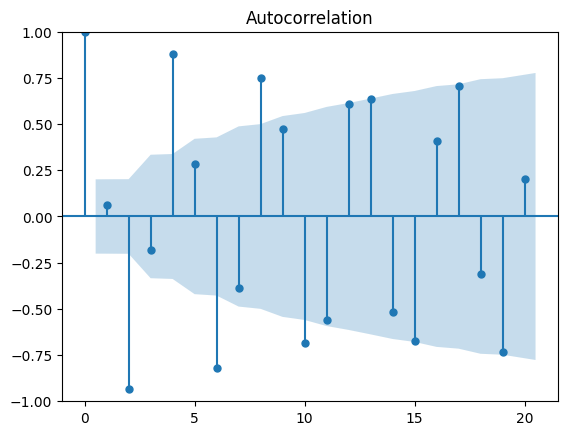

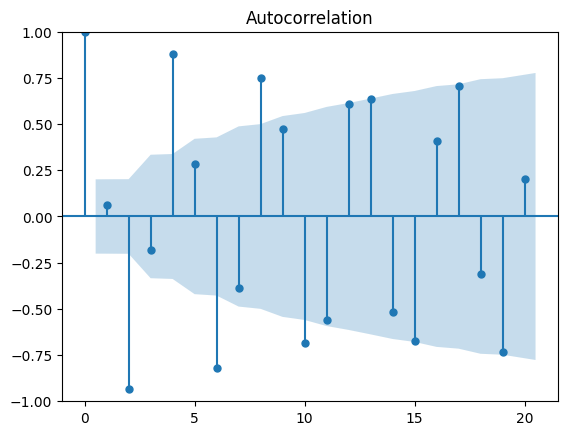

In [ ]:
plot_acf(df[target_variable_transformed].dropna(), lags= 20)

### Now Training MA Model

In [ ]:
def train_MA(df, train_length, steps):

    # Initializing list to store predictions
    pred_MA = []
    test = df[train_length:]

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (0, 0, steps))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_MA.append(output)

    return pred_MA

# Defining train and test lengths
train_len = int(0.8 * len(df))
test_len = len(df) - train_len

# Calling function
steps = 3
MA_predictions = train_MA(df[target_variable_transformed], train_len, steps)
print(MA_predictions)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[76    109.403429
dtype: float64, 77   -119.627711
dtype: float64, 78   -147.633539
dtype: float64, 79    13.622467
dtype: float64, 80    136.882308
dtype: float64, 81    62.492543
dtype: float64, 82   -170.5203
dtype: float64, 83    20.116742
dtype: float64, 84    98.060087
dtype: float64, 85   -25.266196
dtype: float64, 86   -107.718594
dtype: float64, 87   -90.604654
dtype: float64, 88    18.953858
dtype: float64, 89    101.134882
dtype: float64, 90   -243.590409
dtype: float64, 91   -80.367122
dtype: float64, 92    42.861606
dtype: float64, 93    124.956044
dtype: float64, 94   -82.112758
dtype: float64, 95   -198.99166
dtype: float64]


In [34]:
def graph_results(df, target_varaible, train_len, MA_predictions, model_type):
      fig, ax = plt.subplots(figsize=(8, 6))
      MA_mape = mean_absolute_percentage_error(df[target_varaible][train_len:], MA_predictions)

      # Actual Values
      ax.plot(df['quarter'][train_len:], 
            df[target_varaible][train_len:], color='RED')

      # Predicted values
      ax.plot(df['quarter'][train_len:],
            MA_predictions, color='BLUE')

      ax.set_title("Predicted versus Actual {model}-Model ".format(model = model_type) + str(round(MA_mape, 2)))
      plt.show()

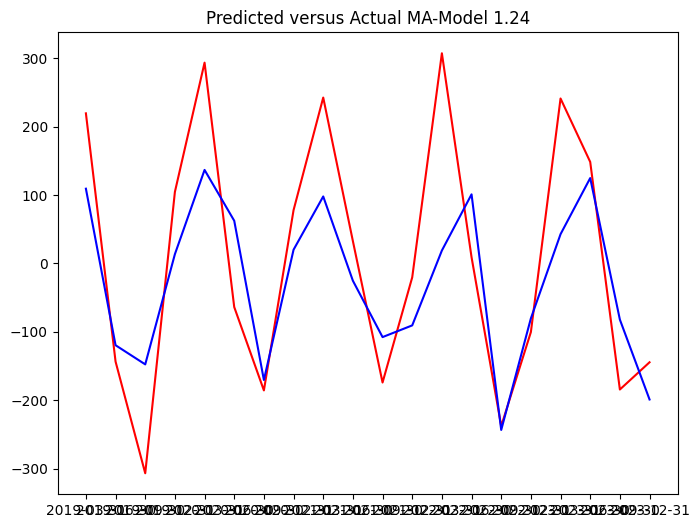

In [ ]:
graph_results(df, target_variable_transformed, train_len, MA_predictions, 'MA')

### Now Finding Best MA Model

In [ ]:
def find_best_ma(df, timesteps_back):

    results = []

    for i in timesteps_back:
        model = SARIMAX(df, order= (0, 0, i))
        model_fit = model.fit()
        results.append(model_fit.aic)
    
    results_df = pd.DataFrame({'Steps Back': timesteps_back,
                               'AIC': results}).sort_values(by = 'AIC', ascending=True).reset_index(drop=True)
    return results_df

# calling function
timesteps_back = range(1,10)
ma_model_compare = find_best_ma(df[target_variable_transformed], timesteps_back)
ma_model_compare.head(10)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,Steps Back,AIC
0,9,1115.232036
1,7,1122.790426
2,8,1130.619952
3,6,1141.478241
4,5,1146.434214
5,4,1153.066520
6,3,1180.189128
7,2,1199.266213
8,1,1239.539775


### Now Fitting Best MA Model

In [ ]:
best_steps = ma_model_compare['Steps Back'][0]
best_MA_predictions = train_MA(df[target_variable_transformed], train_len, best_steps)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-

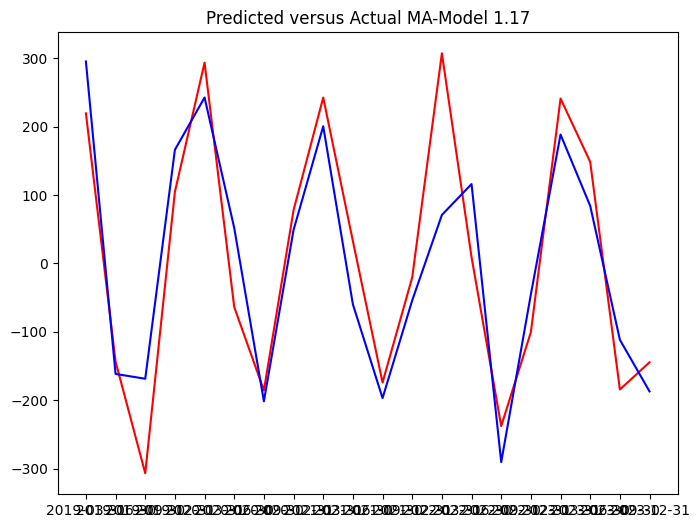

In [ ]:
graph_results(df, target_variable_transformed, train_len, best_MA_predictions, 'MA')

### First Autoregressor Approach

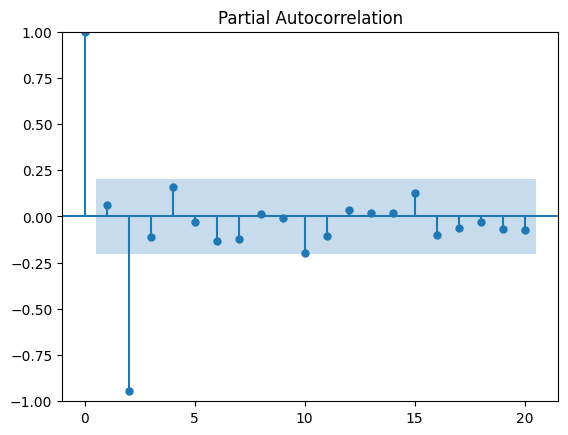

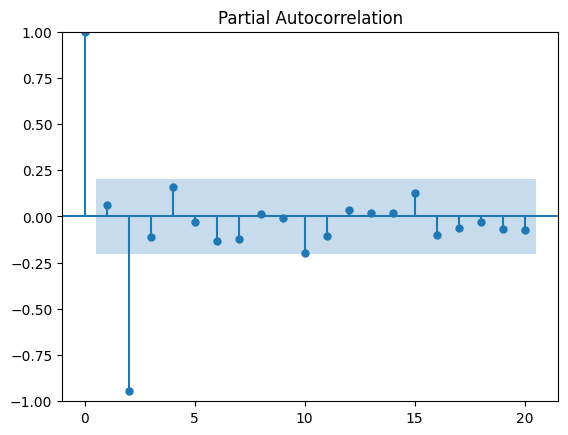

In [ ]:
plot_pacf(df[target_variable_transformed].dropna(), lags= 20)

In [40]:
def train_AR(df, train_length, steps):

    # Initializing list to store predictions
    pred_AR = []
    test = df[train_length:]

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (steps, 0, 0))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_AR.append(output)

    return pred_AR

In [ ]:
# Calling AR function
steps = 2
AR_predictions = train_AR(df[target_variable_transformed], train_len, steps)
print(AR_predictions)

[76    300.726446
dtype: float64, 77   -178.803611
dtype: float64, 78   -227.314922
dtype: float64, 79    98.43334
dtype: float64, 80    307.412777
dtype: float64, 81   -63.17161
dtype: float64, 82   -289.473123
dtype: float64, 83    37.707696
dtype: float64, 84    186.406145
dtype: float64, 85   -44.55743
dtype: float64, 86   -227.066188
dtype: float64, 87   -53.528902
dtype: float64, 88    162.890288
dtype: float64, 89    58.318042
dtype: float64, 90   -292.208308
dtype: float64, 91   -37.772636
dtype: float64, 92    213.541228
dtype: float64, 93    125.91979
dtype: float64, 94   -211.100561
dtype: float64, 95   -165.056025
dtype: float64]


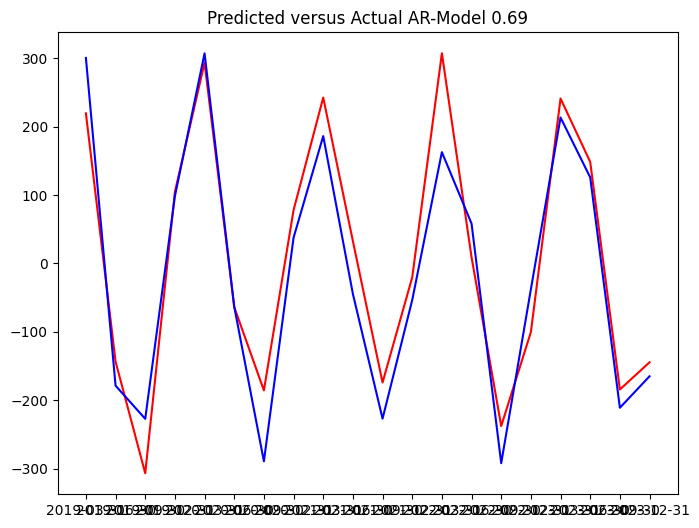

In [ ]:
graph_results(df, target_variable_transformed, train_len, AR_predictions, 'AR')

In [ ]:
# Finding best AR Model
def find_best_ar(df, timesteps_back):

    results = []

    for i in timesteps_back:
        model = SARIMAX(df, order= (i, 0, 0))
        model_fit = model.fit()
        results.append(model_fit.aic)
    
    results_df = pd.DataFrame({'Steps Back': timesteps_back,
                               'AIC': results}).sort_values(by = 'AIC', ascending=True).reset_index(drop=True)
    return results_df

# calling function
ar_model_compare = find_best_ar(df[target_variable_transformed], timesteps_back)
ar_model_compare.head(10)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,Steps Back,AIC
0,9,1036.536591
1,8,1037.682033
2,7,1041.711568
3,4,1041.862708
4,6,1042.305162
5,5,1043.719084
6,2,1054.781864
7,3,1056.779468
8,1,1278.059679


In [ ]:
best_steps = ar_model_compare['Steps Back'][0]
best_AR_predictions = train_AR(df[target_variable_transformed], train_len, best_steps)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.

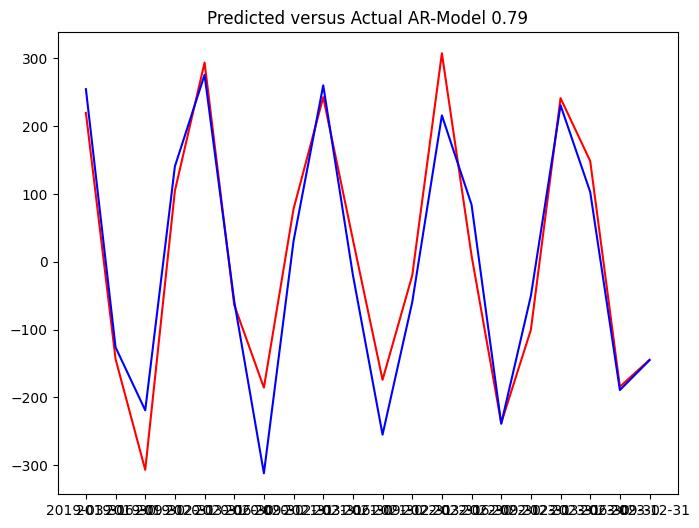

In [ ]:
graph_results(df, target_variable_transformed, train_len, best_AR_predictions, 'AR')

### ARIMA Modeling Approach

In [46]:
# Defining modeling function
def optimize_ARMA(endog,  order_list):
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order = (order[0], order[1], order[2]),
                simple_differencing=False).fit(disp = False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue
    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,d,q)', 'AIC']
    # sorting results
    results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return results_df

In [ ]:
# normal variables
p = range(0, 4, 1)
d = range(0,1,1)
q = range(0, 4, 1)
# Combining parameters
parameters = product(p,d, q)

# Training models
results_df = optimize_ARMA(df[target_variable_transformed], parameters)

# viewing results
print(results_df.sort_values(by = ['AIC']))

8it [00:00, 29.83it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

15it [00:00, 17.72it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

16it [00:00, 18.08it/s]

      (p,d,q)          AIC
0   (2, 0, 2)  1009.082589
1   (3, 0, 2)  1011.265079
2   (2, 0, 3)  1013.084504
3   (3, 0, 3)  1018.383044
4   (2, 0, 0)  1054.781864
5   (3, 0, 1)  1055.455354
6   (3, 0, 0)  1056.779468
7   (2, 0, 1)  1056.779748
8   (0, 0, 3)  1180.189128
9   (1, 0, 3)  1180.716280
10  (0, 0, 2)  1199.266213
11  (1, 0, 2)  1200.961976
12  (0, 0, 1)  1239.539775
13  (1, 0, 1)  1240.561080
14  (0, 0, 0)  1276.445681
15  (1, 0, 0)  1278.059679


### Training Optimal ARIMA

In [ ]:
# defining function for model training
def train_ARIMA_optimal(df,  train_length, order):

    # Initializing list to store predictions
    pred_arima = []
    predictions = []

    test = df[train_length:]

    for month in range(len(test)):
        model = SARIMAX(df[:train_len + month], 
                        order= order)
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_arima.append(output)
        actual_val = list(df)[train_len + month]

    return pred_arima

# calling function and returning predictions
order = (2, 0, 2)
optimal_ARMA_predictions = train_ARIMA_optimal(df[target_variable_transformed], train_len, order)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.

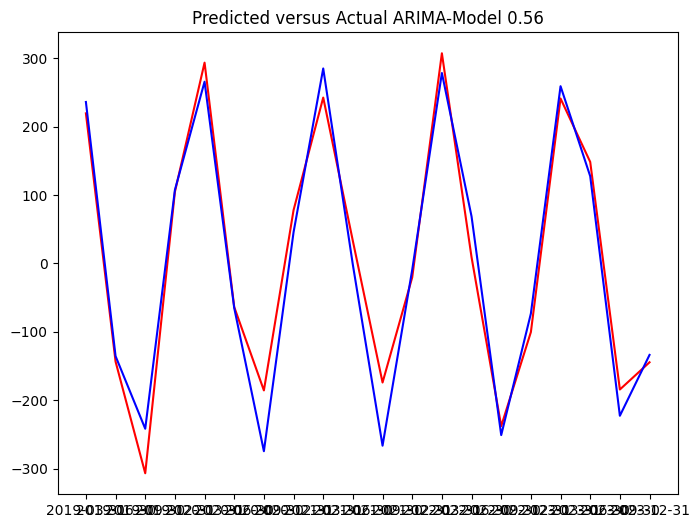

In [ ]:
graph_results(df, target_variable_transformed, train_len, optimal_ARMA_predictions, 'ARIMA')